# CRND Pipeline: Cross-Representation Neighborhood Dissonance with Ecological Niche Overlap

**What this notebook does:**

This demo implements the Cross-Representation Neighborhood Dissonance (CRND) pipeline, which computes per-instance scores measuring how much an instance's k-nearest neighbors disagree across different feature representations:

1. **Feature Space Construction** — Builds 3 feature representations: TF-IDF (sparse bag-of-words), sentence-transformer embeddings (dense semantic), and simulated LLM zero-shot probabilities (class-level softmax).
2. **k-NN & CRND Scoring** — For each instance, finds k-nearest neighbors in each space, then computes CRND = 1 − mean pairwise Jaccard similarity of neighborhoods across spaces. High CRND = neighborhoods disagree across representations.
3. **Baseline Comparison** — Single-space k-NN label entropy in TF-IDF space (no cross-representation signal).
4. **Ecological Niche Overlap** — Schoener's D overlap matrices via PCA+KDE, measuring how much class distributions overlap in each feature space.
5. **Noise Detection Validation** — Injects label noise at different rates and tests whether CRND scores can detect mislabeled instances (via Spearman ρ and ROC-AUC).
6. **Per-class & Boundary Analysis** — CRND statistics stratified by class and by decision boundary proximity.

In [1]:
import subprocess, sys
def _pip(*a): subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', *a])

# sentence-transformers: on Colab torch is pre-installed so this is fast (~10s).
# Locally without torch pre-installed, installing takes >5min (torch ~2GB download).
# We attempt install with a timeout; if it fails, we use a TruncatedSVD fallback.
USE_SENTENCE_TRANSFORMERS = False
try:
    import sentence_transformers
    USE_SENTENCE_TRANSFORMERS = True
except ImportError:
    try:
        subprocess.check_call(
            [sys.executable, '-m', 'pip', 'install', '-q', 'sentence-transformers'],
            timeout=120
        )
        USE_SENTENCE_TRANSFORMERS = True
    except (subprocess.TimeoutExpired, subprocess.CalledProcessError):
        print("sentence-transformers install timed out; using TruncatedSVD fallback for dense embeddings")

# Core packages (pre-installed on Colab, install locally to match Colab env)
if 'google.colab' not in sys.modules:
    _pip('numpy==2.0.2', 'pandas==2.2.2', 'scikit-learn==1.6.1', 'scipy==1.16.3', 'matplotlib==3.10.0')

sentence-transformers install timed out; using TruncatedSVD fallback for dense embeddings



[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python3.12 -m pip install --upgrade pip


## Imports

In [2]:
import gc
import json
import os
import re
import sys
import time
from collections import Counter
from pathlib import Path

import numpy as np
import pandas as pd
import scipy.sparse
from scipy.special import softmax
from scipy.stats import gaussian_kde, kendalltau, spearmanr
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

## Data Loading

In [3]:
GITHUB_DATA_URL = "https://raw.githubusercontent.com/AMGrobelnik/ai-invention-e0166a-cross-representation-neighborhood-disson/main/experiment_iter2_crnd_pipeline_c/demo/mini_demo_data.json"

def load_data():
    try:
        import urllib.request
        with urllib.request.urlopen(GITHUB_DATA_URL) as response:
            return json.loads(response.read().decode())
    except Exception: pass
    if os.path.exists("mini_demo_data.json"):
        with open("mini_demo_data.json") as f: return json.load(f)
    raise FileNotFoundError("Could not load mini_demo_data.json")

In [4]:
data = load_data()
print(f"Loaded {len(data['datasets'])} dataset(s)")
for ds in data["datasets"]:
    print(f"  {ds['dataset']}: {len(ds['examples'])} examples")

Loaded 1 dataset(s)
  medical_abstracts: 30 examples


## Configuration

All tunable parameters are defined here. Start with minimum values to verify correctness, then scale up.

In [5]:
# --- Tunable Parameters ---
# Original values from full experiment are in comments

K_VALUES = [10, 20]              # Original: [10, 20]
NOISE_RATES = [0.05, 0.10, 0.20] # Original: [0.05, 0.10, 0.20]
N_NOISE_SEEDS = 10               # Original: 10
PCA_DIMS = [2, 5]                # Original: [2, 5]
KDE_GRID_SIZE = 100              # Original: 100
MAX_EXAMPLES = None              # Original: 1000 (None = use all in mini data)
TFIDF_MAX_FEATURES = 5000        # Original: 5000
SENTENCE_BATCH_SIZE = 256        # Original: 256

## Phase 0: Parse Datasets

Load and parse datasets from the demo data file. Each dataset has text examples with class labels.

In [6]:
def parse_datasets(raw, max_examples=None):
    """Parse datasets from loaded JSON.
    Returns dict: {dataset_name: {"texts": [...], "labels": [...], "n_classes": int, "class_names": [...], "raw_examples": [...]}}
    """
    datasets = {}
    for ds in raw["datasets"]:
        name = ds["dataset"]
        examples = ds["examples"]
        if max_examples is not None:
            examples = examples[:max_examples]

        texts = [ex["input"] for ex in examples]
        labels = [ex["output"] for ex in examples]
        class_names = sorted(set(labels))

        datasets[name] = {
            "texts": texts,
            "labels": labels,
            "n_classes": len(class_names),
            "class_names": class_names,
            "raw_examples": examples,
        }

        label_counts = Counter(labels)
        print(f"  {name}: {len(texts)} examples, {len(class_names)} classes")
        for label, count in sorted(label_counts.items(), key=lambda x: -x[1])[:5]:
            print(f"    {label}: {count}")

    print(f"Loaded {len(datasets)} datasets total")
    return datasets

datasets = parse_datasets(data, max_examples=MAX_EXAMPLES)

  medical_abstracts: 30 examples, 5 classes
    Cardiovascular_diseases: 6
    Digestive_system_diseases: 6
    General_pathological_conditions: 6
    Neoplasms: 6
    Nervous_system_diseases: 6
Loaded 1 datasets total


## Phase 1: Feature Space Construction

Build three feature representations for each dataset:
- **TF-IDF**: Sparse bag-of-words with bigrams and sublinear TF scaling
- **Sentence Embeddings**: Dense vectors from `all-MiniLM-L6-v2` (or TruncatedSVD fallback if sentence-transformers is unavailable)
- **Simulated LLM Features**: TF-IDF class-centroid cosine similarities → softmax (deterministic proxy for LLM zero-shot classification)

In [7]:
def compute_sentence_embeddings(texts, batch_size=32):
    """Dense embeddings from all-MiniLM-L6-v2, or TruncatedSVD fallback."""
    if USE_SENTENCE_TRANSFORMERS:
        from sentence_transformers import SentenceTransformer
        model = SentenceTransformer("all-MiniLM-L6-v2")
        truncated_texts = [t[:512] if len(t) > 512 else t for t in texts]
        embeddings = model.encode(
            truncated_texts,
            batch_size=batch_size,
            show_progress_bar=False,
            normalize_embeddings=True,
        )
        print(f"  Sentence embeddings (transformer): {embeddings.shape}")
        return embeddings
    else:
        # Fallback: use TruncatedSVD on a separate TF-IDF with different settings
        # to produce a distinct dense feature space
        from sklearn.feature_extraction.text import TfidfVectorizer
        from sklearn.decomposition import TruncatedSVD
        from sklearn.preprocessing import normalize
        vec = TfidfVectorizer(max_features=3000, ngram_range=(1, 3), min_df=1, sublinear_tf=True)
        tfidf = vec.fit_transform(texts)
        n_components = min(64, tfidf.shape[1] - 1, tfidf.shape[0] - 1)
        if n_components < 1:
            n_components = 1
        svd = TruncatedSVD(n_components=n_components, random_state=42)
        embeddings = normalize(svd.fit_transform(tfidf))
        print(f"  Sentence embeddings (SVD fallback): {embeddings.shape}")
        return embeddings


def compute_simulated_llm_features(tfidf_matrix, labels, class_names):
    """Simulate LLM features using TF-IDF class centroids + cosine → softmax."""
    n_classes = len(class_names)
    labels_arr = np.array(labels)

    centroids = np.zeros((n_classes, tfidf_matrix.shape[1]))
    for i, cls in enumerate(class_names):
        mask = labels_arr == cls
        if mask.sum() > 0:
            centroids[i] = np.asarray(tfidf_matrix[mask].mean(axis=0)).ravel()

    sims = cosine_similarity(tfidf_matrix, centroids)
    features = softmax(sims * 3.0, axis=1)
    print(f"  Simulated LLM features: {features.shape}")
    return features

## Phase 2: k-NN Computation & CRND Scores

CRND(i) = 1 − mean pairwise Jaccard similarity of k-NN neighborhoods across feature spaces.

High CRND means the instance's neighbors differ substantially depending on the representation — a signal of complexity or ambiguity.

In [8]:
def compute_knn_neighbors(feature_matrix, k=20, metric="cosine"):
    """Compute k-nearest neighbor indices for all instances."""
    n = feature_matrix.shape[0] if hasattr(feature_matrix, "shape") else len(feature_matrix)
    actual_k = min(k, n - 1)
    if actual_k < 1:
        return np.zeros((n, 0), dtype=int)

    nn = NearestNeighbors(n_neighbors=actual_k + 1, metric=metric, algorithm="auto")
    nn.fit(feature_matrix)
    _, indices = nn.kneighbors(feature_matrix)
    neighbor_indices = indices[:, 1:]
    return neighbor_indices


def compute_crnd(neighbor_sets, k=20):
    """Compute Cross-Representation Neighborhood Dissonance.
    CRND(i) = 1 - mean of pairwise Jaccard similarities across feature spaces.
    """
    space_names = list(neighbor_sets.keys())
    n_instances = neighbor_sets[space_names[0]].shape[0]
    actual_k = neighbor_sets[space_names[0]].shape[1]

    if actual_k == 0:
        return np.zeros(n_instances)

    sorted_neighbors = {
        name: np.sort(arr, axis=1) for name, arr in neighbor_sets.items()
    }

    pairs = []
    for a in range(len(space_names)):
        for b in range(a + 1, len(space_names)):
            pairs.append((space_names[a], space_names[b]))

    n_pairs = len(pairs)
    jaccard_sums = np.zeros(n_instances)

    for name_a, name_b in pairs:
        arr_a = sorted_neighbors[name_a]
        arr_b = sorted_neighbors[name_b]
        for i in range(n_instances):
            set_a = set(arr_a[i].tolist())
            set_b = set(arr_b[i].tolist())
            union_size = len(set_a | set_b)
            if union_size > 0:
                jaccard_sums[i] += len(set_a & set_b) / union_size

    crnd_scores = 1.0 - jaccard_sums / n_pairs
    return crnd_scores

## Baseline: Single-Space k-NN Label Entropy

For comparison, compute the Shannon entropy of label distributions among k-nearest neighbors in TF-IDF space alone. Higher entropy = more ambiguous region.

In [9]:
def compute_baseline_knn_entropy(knn_indices, labels, class_names):
    """Baseline: k-NN label entropy in a single feature space."""
    n = knn_indices.shape[0]
    k = knn_indices.shape[1]
    if k == 0:
        return np.zeros(n)

    label_to_idx = {cls: i for i, cls in enumerate(class_names)}
    labels_int = np.array([label_to_idx[l] for l in labels])
    n_classes = len(class_names)

    entropy_scores = np.zeros(n)
    for i in range(n):
        neighbor_label_ints = labels_int[knn_indices[i]]
        counts = np.bincount(neighbor_label_ints, minlength=n_classes)
        probs = counts / k
        probs = probs[probs > 0]
        entropy_scores[i] = -np.sum(probs * np.log2(probs))

    return entropy_scores

## Phase 3: Ecological Niche Overlap (Schoener's D)

Compute pairwise class overlap using KDE on PCA-projected features. Schoener's D ∈ [0, 1], where 1 = identical distributions.

In [10]:
def compute_schoeners_d_matrix(feature_matrix, labels, class_names, n_pca_dims=2, grid_size=100):
    """Compute Schoener's D pairwise overlap matrix using PCA-env framework."""
    labels_arr = np.array(labels)
    n_samples, n_features = feature_matrix.shape[0], feature_matrix.shape[1]

    if hasattr(feature_matrix, "toarray"):
        actual_dims = min(n_pca_dims, n_features - 1, n_samples - 1)
        if actual_dims < 1:
            n_cls = len(class_names)
            return np.eye(n_cls), {"explained_variance": [], "n_pca_dims": 0, "grid_size": 0}
        svd = TruncatedSVD(n_components=actual_dims, random_state=42)
        projected = svd.fit_transform(feature_matrix)
        explained_var = svd.explained_variance_ratio_
    else:
        actual_dims = min(n_pca_dims, n_features, n_samples - 1)
        if actual_dims < 1:
            n_cls = len(class_names)
            return np.eye(n_cls), {"explained_variance": [], "n_pca_dims": 0, "grid_size": 0}
        pca = PCA(n_components=actual_dims, random_state=42)
        projected = pca.fit_transform(feature_matrix)
        explained_var = pca.explained_variance_ratio_

    actual_dims = projected.shape[1]
    mins = projected.min(axis=0)
    maxs = projected.max(axis=0)
    padding = (maxs - mins) * 0.05 + 1e-10

    if actual_dims <= 2:
        grid_1d = [
            np.linspace(mins[d] - padding[d], maxs[d] + padding[d], grid_size)
            for d in range(actual_dims)
        ]
        if actual_dims == 2:
            mesh = np.meshgrid(*grid_1d)
            grid_points = np.vstack([m.ravel() for m in mesh])
        else:
            grid_points = grid_1d[0].reshape(1, -1)
    else:
        pts_per_dim = max(5, int(round(100000 ** (1.0 / actual_dims))))
        grid_1d = [
            np.linspace(mins[d] - padding[d], maxs[d] + padding[d], pts_per_dim)
            for d in range(actual_dims)
        ]
        mesh = np.meshgrid(*grid_1d, indexing="ij")
        grid_points = np.vstack([m.ravel() for m in mesh])

    n_classes = len(class_names)
    class_densities = {}

    for cls in class_names:
        mask = labels_arr == cls
        n_cls = int(mask.sum())

        if n_cls < actual_dims + 1:
            class_densities[cls] = np.ones(grid_points.shape[1]) / grid_points.shape[1]
            continue

        cls_data = projected[mask].T
        try:
            jitter = np.random.default_rng(42).normal(0, 1e-8, cls_data.shape)
            kde = gaussian_kde(cls_data + jitter, bw_method="scott")
            density = kde.evaluate(grid_points)
        except np.linalg.LinAlgError:
            try:
                kde = gaussian_kde(cls_data + jitter, bw_method="silverman")
                density = kde.evaluate(grid_points)
            except np.linalg.LinAlgError:
                density = np.ones(grid_points.shape[1]) / grid_points.shape[1]

        total = density.sum()
        if total > 0:
            density = density / total
        class_densities[cls] = density

    D_matrix = np.zeros((n_classes, n_classes))
    for i in range(n_classes):
        for j in range(i + 1, n_classes):
            p1 = class_densities[class_names[i]]
            p2 = class_densities[class_names[j]]
            D_val = 1.0 - 0.5 * np.sum(np.abs(p1 - p2))
            D_matrix[i, j] = D_val
            D_matrix[j, i] = D_val
        D_matrix[i, i] = 1.0

    return D_matrix, {
        "explained_variance": explained_var.tolist(),
        "n_pca_dims": actual_dims,
        "grid_size": grid_size,
    }

## Phase 4: Noise Injection & Validation

Inject random label noise and test whether CRND (vs baseline entropy) can detect which instances were corrupted.

In [11]:
def inject_label_noise(labels, noise_rate, class_names, seed):
    """Inject uniform label noise. Returns (noisy_labels, noise_indicator)."""
    rng = np.random.default_rng(seed)
    n = len(labels)

    if len(class_names) < 2:
        return list(labels), np.zeros(n, dtype=int)

    n_flip = int(n * noise_rate)
    if n_flip == 0:
        return list(labels), np.zeros(n, dtype=int)

    flip_indices = rng.choice(n, size=n_flip, replace=False)
    noise_indicator = np.zeros(n, dtype=int)
    noise_indicator[flip_indices] = 1

    noisy_labels = list(labels)
    for idx in flip_indices:
        original = noisy_labels[idx]
        candidates = [c for c in class_names if c != original]
        if candidates:
            noisy_labels[idx] = rng.choice(candidates)
        else:
            noise_indicator[idx] = 0

    return noisy_labels, noise_indicator


def evaluate_noise_detection(scores, noise_indicator):
    """Compute Spearman correlation and ROC-AUC of a score as noise detector."""
    rho, p_value = spearmanr(scores, noise_indicator)
    try:
        if len(np.unique(noise_indicator)) < 2:
            auc = float("nan")
        else:
            auc = roc_auc_score(noise_indicator, scores)
    except ValueError:
        auc = float("nan")

    return {
        "spearman_rho": float(rho) if np.isfinite(rho) else 0.0,
        "spearman_p_value": float(p_value) if np.isfinite(p_value) else 1.0,
        "roc_auc": float(auc) if np.isfinite(auc) else 0.5,
        "n_noisy": int(noise_indicator.sum()),
        "n_clean": int((1 - noise_indicator).sum()),
    }

## Phase 5: Additional Analyses

Per-class CRND statistics and boundary proximity stratification.

In [12]:
def analyze_crnd_by_class(crnd_scores, labels, class_names):
    """Compute CRND statistics per class."""
    labels_arr = np.array(labels)
    results = {}
    for cls in class_names:
        mask = labels_arr == cls
        cls_crnd = crnd_scores[mask]
        if len(cls_crnd) == 0:
            continue
        results[cls] = {
            "mean": float(np.mean(cls_crnd)),
            "std": float(np.std(cls_crnd)),
            "median": float(np.median(cls_crnd)),
            "q25": float(np.percentile(cls_crnd, 25)),
            "q75": float(np.percentile(cls_crnd, 75)),
            "n": int(mask.sum()),
        }
    return results


def analyze_boundary_proximity(crnd_scores, labels, knn_indices_all_spaces, class_names):
    """Stratify CRND by boundary proximity (fraction of k-NN with different label)."""
    n = len(labels)
    labels_arr = np.array(labels)

    boundary_scores = np.zeros(n)
    for space_name, knn_idx in knn_indices_all_spaces.items():
        for i in range(n):
            if knn_idx.shape[1] == 0:
                continue
            neighbor_labels = labels_arr[knn_idx[i]]
            frac_different = np.mean(neighbor_labels != labels_arr[i])
            boundary_scores[i] += frac_different
    boundary_scores /= max(len(knn_indices_all_spaces), 1)

    bins = [0, 0.2, 0.4, 0.6, 0.8, 1.01]
    bin_labels = ["0.0-0.2", "0.2-0.4", "0.4-0.6", "0.6-0.8", "0.8-1.0"]
    digitized = np.digitize(boundary_scores, bins) - 1

    stratified = {}
    for b, label in enumerate(bin_labels):
        mask = digitized == b
        if mask.sum() > 0:
            stratified[label] = {
                "mean_crnd": float(np.mean(crnd_scores[mask])),
                "std_crnd": float(np.std(crnd_scores[mask])),
                "count": int(mask.sum()),
            }
    return stratified, boundary_scores

## Run Full Pipeline

Process each dataset through all phases: feature extraction → k-NN + CRND → Schoener's D → noise validation → per-class + boundary analysis.

In [13]:
t_total_start = time.time()

# Collect all results
all_results = {}

for ds_name, ds_data in datasets.items():
    texts = ds_data["texts"]
    labels = ds_data["labels"]
    class_names = ds_data["class_names"]
    n = len(texts)

    print(f"\n{'='*60}")
    print(f"Processing dataset: {ds_name} ({n} examples, {len(class_names)} classes)")
    print(f"{'='*60}")

    t0 = time.time()

    # --- Feature Extraction ---
    print("Computing TF-IDF features...")
    min_df = 2 if n > 10 else 1
    max_features = min(TFIDF_MAX_FEATURES, n * 10)
    tfidf_vectorizer = TfidfVectorizer(
        max_features=max_features,
        stop_words="english",
        ngram_range=(1, 2),
        min_df=min_df,
        max_df=0.95,
        sublinear_tf=True,
    )
    tfidf_matrix = tfidf_vectorizer.fit_transform(texts)
    print(f"  TF-IDF: {tfidf_matrix.shape}, nnz={tfidf_matrix.nnz}")

    print("Computing sentence embeddings...")
    sent_embeddings = compute_sentence_embeddings(texts, batch_size=SENTENCE_BATCH_SIZE)

    print("Computing simulated LLM features...")
    llm_features = compute_simulated_llm_features(tfidf_matrix, labels, class_names)

    feature_spaces = {
        "tfidf": tfidf_matrix,
        "sentence_transformer": sent_embeddings,
        "llm_zeroshot": llm_features,
    }

    # --- k-NN & CRND ---
    crnd_results = {}
    knn_results = {}
    baseline_results = {}

    for k_val in K_VALUES:
        print(f"Computing k-NN with k={k_val}...")
        neighbor_sets = {}
        for space_name, feat_mat in feature_spaces.items():
            neighbors = compute_knn_neighbors(feat_mat, k=k_val, metric="cosine")
            neighbor_sets[space_name] = neighbors
            knn_results[f"{space_name}_k{k_val}"] = neighbors

        print(f"Computing CRND scores (k={k_val})...")
        crnd = compute_crnd(neighbor_sets, k=k_val)
        crnd_results[f"k{k_val}"] = crnd

        print(f"Computing baseline k-NN entropy (k={k_val})...")
        baseline_entropy = compute_baseline_knn_entropy(
            knn_indices=neighbor_sets["tfidf"],
            labels=labels,
            class_names=class_names,
        )
        baseline_results[f"k{k_val}"] = baseline_entropy

        print(f"  CRND: mean={np.mean(crnd):.4f}, std={np.std(crnd):.4f}")
        print(f"  Baseline entropy: mean={np.mean(baseline_entropy):.4f}, std={np.std(baseline_entropy):.4f}")

    # --- Schoener's D matrices ---
    print("Computing Schoener's D matrices...")
    ds_schoeners = {}
    for space_name, feat_mat in feature_spaces.items():
        for pca_dim in PCA_DIMS:
            key = f"{space_name}_{pca_dim}d"
            print(f"  Schoener's D: {key}...")
            try:
                gs = KDE_GRID_SIZE if pca_dim <= 2 else max(5, int(round(50000 ** (1.0 / pca_dim))))
                D_mat, pca_info = compute_schoeners_d_matrix(
                    feature_matrix=feat_mat,
                    labels=labels,
                    class_names=class_names,
                    n_pca_dims=pca_dim,
                    grid_size=gs,
                )
                ds_schoeners[key] = D_mat.tolist()
            except Exception as e:
                print(f"  Failed: {e}")
                ds_schoeners[key] = np.eye(len(class_names)).tolist()

    # --- Noise Detection Validation ---
    print("Running noise detection validation...")
    # Use the first k value for noise detection
    k_key = f"k{K_VALUES[0]}"
    noise_results = {}

    for nr in NOISE_RATES:
        auc_vals_crnd = []
        auc_vals_base = []
        for seed in range(N_NOISE_SEEDS):
            _, noise_indicator = inject_label_noise(labels, nr, class_names, seed)
            eval_crnd = evaluate_noise_detection(crnd_results[k_key], noise_indicator)
            eval_base = evaluate_noise_detection(baseline_results[k_key], noise_indicator)
            auc_vals_crnd.append(eval_crnd["roc_auc"])
            auc_vals_base.append(eval_base["roc_auc"])

        noise_results[str(nr)] = {
            "crnd_mean_auc": float(np.mean(auc_vals_crnd)),
            "crnd_std_auc": float(np.std(auc_vals_crnd)),
            "baseline_mean_auc": float(np.mean(auc_vals_base)),
            "baseline_std_auc": float(np.std(auc_vals_base)),
        }
        print(f"  Noise {nr:.0%}: CRND AUC={np.mean(auc_vals_crnd):.4f}±{np.std(auc_vals_crnd):.4f} | "
              f"Baseline AUC={np.mean(auc_vals_base):.4f}±{np.std(auc_vals_base):.4f}")

    # --- Per-class analysis ---
    print("Computing per-class analysis...")
    crnd_per_class = analyze_crnd_by_class(crnd_results[k_key], labels, class_names)

    # --- Boundary proximity ---
    print("Computing boundary proximity stratification...")
    knn_all_spaces = {
        space_name: knn_results[f"{space_name}_k{K_VALUES[0]}"]
        for space_name in feature_spaces
    }
    boundary_strat, boundary_scores = analyze_boundary_proximity(
        crnd_scores=crnd_results[k_key],
        labels=labels,
        knn_indices_all_spaces=knn_all_spaces,
        class_names=class_names,
    )

    total_time = time.time() - t0
    print(f"\nDataset {ds_name} completed in {total_time:.1f}s")

    # Store results
    all_results[ds_name] = {
        "crnd_results": crnd_results,
        "baseline_results": baseline_results,
        "schoeners_d": ds_schoeners,
        "noise_results": noise_results,
        "crnd_per_class": crnd_per_class,
        "boundary_stratification": boundary_strat,
        "boundary_scores": boundary_scores,
        "class_names": class_names,
        "labels": labels,
    }

    del tfidf_matrix, sent_embeddings, llm_features
    gc.collect()

total_time = time.time() - t_total_start
print(f"\n{'='*60}")
print(f"PIPELINE COMPLETE — Total runtime: {total_time:.1f}s ({total_time/60:.1f} min)")
print(f"{'='*60}")


Processing dataset: medical_abstracts (30 examples, 5 classes)
Computing TF-IDF features...
  TF-IDF: (30, 143), nnz=369
Computing sentence embeddings...


  Sentence embeddings (SVD fallback): (30, 29)
Computing simulated LLM features...
  Simulated LLM features: (30, 5)
Computing k-NN with k=10...
Computing CRND scores (k=10)...
Computing baseline k-NN entropy (k=10)...
  CRND: mean=0.6249, std=0.0689
  Baseline entropy: mean=2.0601, std=0.1859
Computing k-NN with k=20...
Computing CRND scores (k=20)...
Computing baseline k-NN entropy (k=20)...
  CRND: mean=0.4007, std=0.0352
  Baseline entropy: mean=2.2451, std=0.0584
Computing Schoener's D matrices...
  Schoener's D: tfidf_2d...
  Schoener's D: tfidf_5d...


  Schoener's D: sentence_transformer_2d...
  Schoener's D: sentence_transformer_5d...


  Schoener's D: llm_zeroshot_2d...
  Schoener's D: llm_zeroshot_5d...


Running noise detection validation...
  Noise 5%: CRND AUC=0.5690±0.3787 | Baseline AUC=0.6448±0.1707
  Noise 10%: CRND AUC=0.4772±0.1932 | Baseline AUC=0.5074±0.1003
  Noise 20%: CRND AUC=0.5212±0.0964 | Baseline AUC=0.4983±0.1496
Computing per-class analysis...
Computing boundary proximity stratification...

Dataset medical_abstracts completed in 1.5s

PIPELINE COMPLETE — Total runtime: 1.6s (0.0 min)


## Results Visualization

Summary tables and plots of key findings across all datasets.

/tmp/ipykernel_2399084/3359800206.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(class_data, labels=class_labels_plot, patch_artist=True)


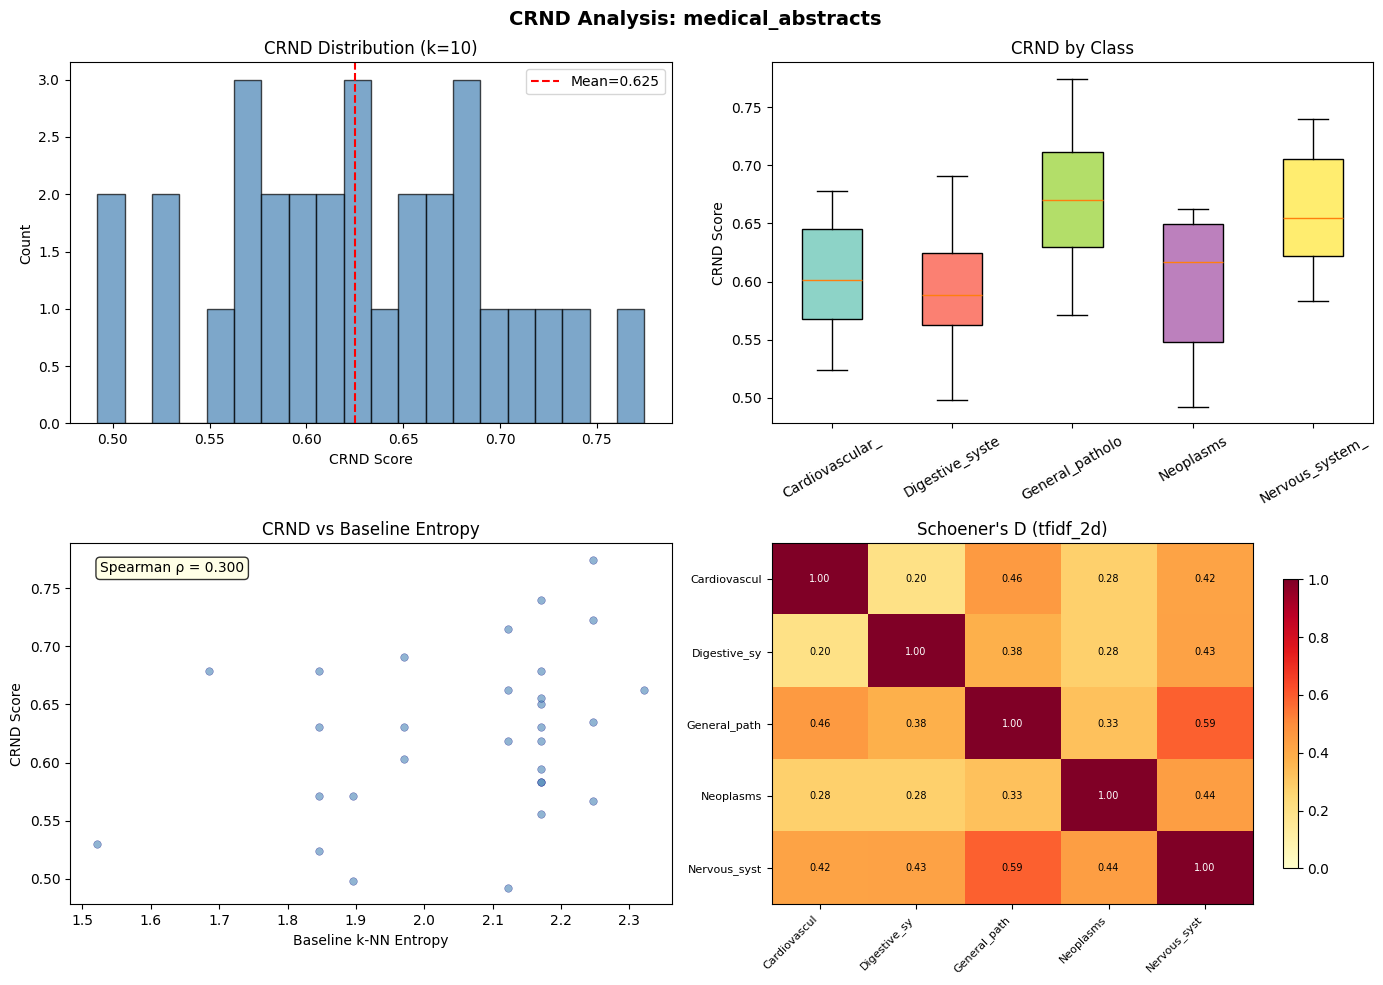


--- Per-Class CRND Summary (medical_abstracts) ---
Class                         Mean      Std   Median     N
----------------------------------------------------------
Cardiovascular_diseases     0.6036   0.0537   0.6012     6
Digestive_system_diseases   0.5928   0.0602   0.5888     6
General_pathological_cond   0.6713   0.0659   0.6705     6
Neoplasms                   0.5957   0.0638   0.6171     6
Nervous_system_diseases     0.6610   0.0549   0.6547     6

--- Noise Detection Results (medical_abstracts) ---
Rate           CRND AUC     Base AUC
------------------------------------
0.05         0.5690±0.3787   0.6448±0.1707
0.1          0.4772±0.1932   0.5074±0.1003
0.2          0.5212±0.0964   0.4983±0.1496

--- Boundary Proximity Stratification (medical_abstracts) ---
Bin           Mean CRND      Std  Count
--------------------------------------
0.4-0.6          0.5317   0.0397      2
0.6-0.8          0.6315   0.0657     28



In [14]:
for ds_name, res in all_results.items():
    k_key = f"k{K_VALUES[0]}"
    crnd_scores = res["crnd_results"][k_key]
    baseline_scores = res["baseline_results"][k_key]
    class_names = res["class_names"]
    labels = res["labels"]
    boundary_scores = res["boundary_scores"]

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f"CRND Analysis: {ds_name}", fontsize=14, fontweight="bold")

    # 1. CRND score distribution
    ax = axes[0, 0]
    ax.hist(crnd_scores, bins=20, alpha=0.7, color="steelblue", edgecolor="black")
    ax.set_xlabel("CRND Score")
    ax.set_ylabel("Count")
    ax.set_title(f"CRND Distribution (k={K_VALUES[0]})")
    ax.axvline(np.mean(crnd_scores), color="red", linestyle="--", label=f"Mean={np.mean(crnd_scores):.3f}")
    ax.legend()

    # 2. Per-class CRND boxplot
    ax = axes[0, 1]
    class_data = []
    class_labels_plot = []
    for cls in class_names:
        mask = np.array(labels) == cls
        class_data.append(crnd_scores[mask])
        class_labels_plot.append(cls[:15])
    bp = ax.boxplot(class_data, labels=class_labels_plot, patch_artist=True)
    colors = plt.cm.Set3(np.linspace(0, 1, len(class_names)))
    for patch, color in zip(bp["boxes"], colors):
        patch.set_facecolor(color)
    ax.set_ylabel("CRND Score")
    ax.set_title("CRND by Class")
    ax.tick_params(axis="x", rotation=30)

    # 3. CRND vs Baseline Entropy scatter
    ax = axes[1, 0]
    ax.scatter(baseline_scores, crnd_scores, alpha=0.6, s=30, c="steelblue", edgecolors="navy", linewidth=0.3)
    ax.set_xlabel("Baseline k-NN Entropy")
    ax.set_ylabel("CRND Score")
    ax.set_title("CRND vs Baseline Entropy")
    if len(crnd_scores) > 2:
        rho, _ = spearmanr(baseline_scores, crnd_scores)
        ax.annotate(f"Spearman ρ = {rho:.3f}", xy=(0.05, 0.95), xycoords="axes fraction",
                    fontsize=10, ha="left", va="top",
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow", alpha=0.8))

    # 4. Schoener's D heatmap (first feature space, first PCA dim)
    ax = axes[1, 1]
    first_key = list(res["schoeners_d"].keys())[0]
    D_mat = np.array(res["schoeners_d"][first_key])
    im = ax.imshow(D_mat, cmap="YlOrRd", vmin=0, vmax=1, aspect="auto")
    ax.set_xticks(range(len(class_names)))
    ax.set_yticks(range(len(class_names)))
    ax.set_xticklabels([c[:12] for c in class_names], rotation=45, ha="right", fontsize=8)
    ax.set_yticklabels([c[:12] for c in class_names], fontsize=8)
    ax.set_title(f"Schoener's D ({first_key})")
    for i in range(D_mat.shape[0]):
        for j in range(D_mat.shape[1]):
            ax.text(j, i, f"{D_mat[i,j]:.2f}", ha="center", va="center", fontsize=7,
                    color="white" if D_mat[i,j] > 0.6 else "black")
    fig.colorbar(im, ax=ax, shrink=0.8)

    plt.tight_layout()
    plt.show()

    # Print summary table
    print(f"\n--- Per-Class CRND Summary ({ds_name}) ---")
    print(f"{'Class':<25} {'Mean':>8} {'Std':>8} {'Median':>8} {'N':>5}")
    print("-" * 58)
    for cls, stats in res["crnd_per_class"].items():
        print(f"{cls[:25]:<25} {stats['mean']:>8.4f} {stats['std']:>8.4f} {stats['median']:>8.4f} {stats['n']:>5}")

    print(f"\n--- Noise Detection Results ({ds_name}) ---")
    print(f"{'Rate':<10} {'CRND AUC':>12} {'Base AUC':>12}")
    print("-" * 36)
    for rate, nr_res in res["noise_results"].items():
        print(f"{rate:<10} {nr_res['crnd_mean_auc']:>8.4f}±{nr_res['crnd_std_auc']:.4f} "
              f"{nr_res['baseline_mean_auc']:>8.4f}±{nr_res['baseline_std_auc']:.4f}")

    print(f"\n--- Boundary Proximity Stratification ({ds_name}) ---")
    print(f"{'Bin':<12} {'Mean CRND':>10} {'Std':>8} {'Count':>6}")
    print("-" * 38)
    for bin_label, stats in res["boundary_stratification"].items():
        print(f"{bin_label:<12} {stats['mean_crnd']:>10.4f} {stats['std_crnd']:>8.4f} {stats['count']:>6}")
    print()